## ERDAP with erddapy example for FCOM ITAE Prawler - 2019 C2 (CKITAEPR-2A)

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 
+ Raw Science Units are what is being hosted on ERDDAP client.    
+ Salinity must be calculated from Conductivity   
+ OxyConc must be corrected for Salinity/Press   
+ Turb/Chlor must be calculated from counts   
+ TELOS ('http://heron:8080/erddap') erddap doesn't keep a divenumber value (and its not trivial to sort this data) so second erddap is hosting this data in order to keep that parameter ('http://downdraft.pmel.noaa.gov:8080/erddap') some preprocessing is happening there prior to data posting.  Incomming -> Science -> QC'd data is a source of future conversation for erddap hosting.

__Todo:__
+ Initial QC can be done   
+ csv files of converted data should be archived at end of deployment?

In [69]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-09-26 09:22:02.498604


### connecting and basic information

In [70]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

import seawater as sw
import calc.aanderaa_corrO2_sal as optode_O2_corr

server_url = 'http://heron:8080/erddap'

e = ERDDAP(server=server_url)

In [71]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAW'))

In [72]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 8 tabledap, 0 griddap, and 0 wms endpoints.'

In [73]:
prawlers = df['Dataset ID'].values
print(prawlers)

['FCOM0001_PRAWE_0001' 'FCOM0001_PRAWC_0001' 'TELO9999_PRAWE_0002'
 'TELO9999_PRAWC_0002' 'TELOF001_PRAWE_F001' 'TELOF001_PRAWC_F001'
 'TELON001_PRAWE_N001' 'TELON001_PRAWC_N001']


In [74]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['Depth', 'SRate', 'IRate', 'time', 'ETimer'], ['SB_Conductivity', 'Optode_Temp', 'time', 'wetlab_FDOM', 'SB_Depth', 'SB_Temp', 'wetlab_Chlorophyll', 'Optode_Dissolved_O2'], ['Depth', 'SRate', 'IRate', 'time', 'ETimer'], ['SB_Conductivity', 'Optode_Temp', 'time', 'wetlab_FDOM', 'Epoch_Time', 'SB_Depth', 'SB_Temp', 'wetlab_Chlorophyll', 'Optode_Dissolved_O2'], ['Depth', 'SRate', 'IRate', 'time', 'ETimer'], ['SB_Conductivity', 'Optode_Temp', 'time', 'wetlab_FDOM', 'Epoch_Time', 'SB_Depth', 'SB_Temp', 'wetlab_Chlorophyll', 'Optode_Dissolved_O2'], ['Depth', 'SRate', 'IRate', 'time', 'ETimer'], ['SB_Conductivity', 'Optode_Temp', 'time', 'wetlab_FDOM', 'Epoch_Time', 'SB_Depth', 'SB_Temp', 'wetlab_Chlorophyll', 'Optode_Dissolved_O2']]


### retrieving and plotting data

In [75]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='TELOF001_PRAWC_F001'

d.variables =  [
 'SB_Depth',
 'SB_Temp',
 'SB_Conductivity',
 'Optode_Temp',
 'Optode_Dissolved_O2',
 'wetlab_Chlorophyll',
 'wetlab_FDOM',
 "time"
]

d.constraints = {
    'time>=': '2019-08-01T00:00:00Z',
    'time<=': '2020-08-01T00:00:00Z',
}

In [76]:
d.get_download_url()

'http://heron:8080/erddap/tabledap/TELOF001_PRAWC_F001.csv?SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,time&time>=1564617600.0&time<=1596240000.0'

In [77]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.head()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2019-08-18 22:17:24+00:00,4.69,8.598,3.269,8.604,363.41,70.0,52.0
2019-08-18 22:17:32+00:00,4.67,8.599,3.270,8.604,363.38,72.0,62.0
2019-08-18 22:17:40+00:00,4.59,8.598,3.270,8.604,363.39,69.0,54.0
2019-08-18 22:17:48+00:00,4.57,8.598,3.270,8.604,363.35,70.0,53.0
2019-08-18 22:17:56+00:00,4.60,8.598,3.270,8.605,363.42,69.0,49.0


In [78]:
df.tail()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2019-09-15 18:41:31+00:00,3.16,7.920,3.209,7.922,350.71,111.0,54.0
2019-09-15 18:41:39+00:00,3.27,7.917,3.209,7.922,350.64,112.0,54.0
2019-09-15 18:41:47+00:00,3.28,7.918,3.209,7.921,350.64,112.0,53.0
2019-09-15 18:41:55+00:00,3.16,7.917,3.209,7.921,350.60,111.0,53.0
2019-09-15 18:42:03+00:00,3.49,7.917,3.209,7.920,350.55,114.0,52.0


#### Temperature

In [79]:
#qc
df['SB_Temp'][df['SB_Temp']>20]=np.nan

In [80]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

Text(0, 0.5, 'Depth (m)')

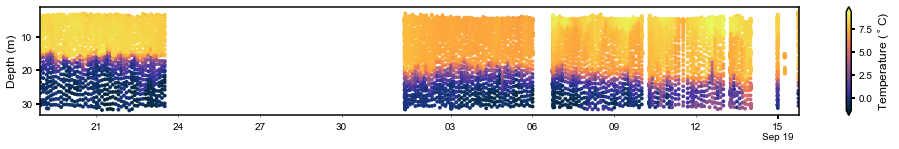

In [82]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal)
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


In [83]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['SB_Temp'].max(), df['SB_Temp'].min()))


max temp: 9.447
min temp: -1.337


#### Salinity

In [84]:
### calculate salinity from conductivity
df['Salinity (PSU)'] = sw.salt(r=df['SB_Conductivity']/4.2914,t=df['SB_Temp'],p=df['SB_Depth'])

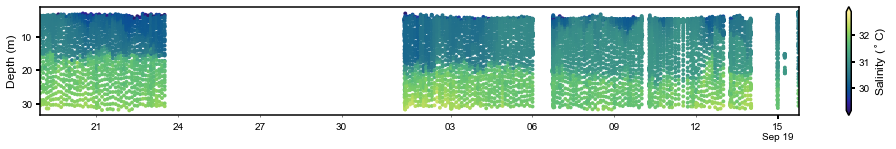

In [85]:
#bounds
lower = df['Salinity (PSU)'].mean()-3*df['Salinity (PSU)'].std()
upper = df['Salinity (PSU)'].mean()+3*df['Salinity (PSU)'].std()

#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Salinity (PSU)'], 
                marker='o', edgecolor='none', vmin=lower, vmax=upper, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [86]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity (PSU)'].max(), df['Salinity (PSU)'].min()))

print("""
mean sal: {0:0.4}
sal std: {1:04}""".format(df['Salinity (PSU)'].mean(),df['Salinity (PSU)'].std()))


max sal: 36.95
min sal: 28.55

mean sal: 31.02
sal std: 0.6225582241259918


#### Chlorophyl

Text(0, 0.5, 'Depth (m)')

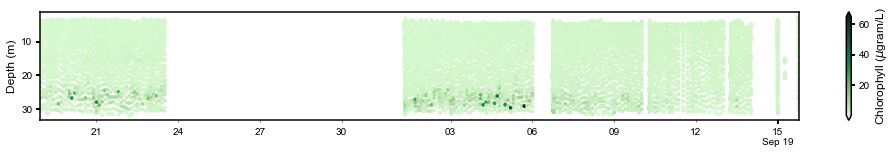

In [87]:
df['wetlab_Chlorophyll_ug/l'] = (df['wetlab_Chlorophyll']-60)*0.0226

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_Chlorophyll_ug/l'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')


In [88]:
print("""
max chlorophyll: {0:0.4}
min chlorophyll: {1:0.4}""".format(df['wetlab_Chlorophyll_ug/l'].max(), df['wetlab_Chlorophyll_ug/l'].min()))


max chlorophyll: 64.84
min chlorophyll: 0.1582


#### Chlorophyl (log scale)

Text(0, 0.5, 'Depth (m)')

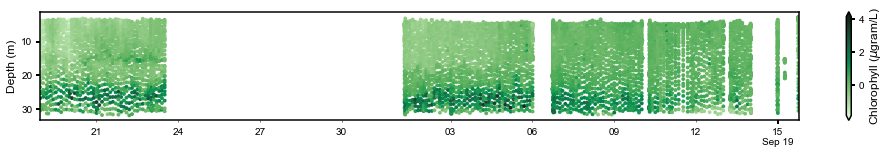

In [89]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=np.log(df['wetlab_Chlorophyll_ug/l']), 
                marker='o', edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')

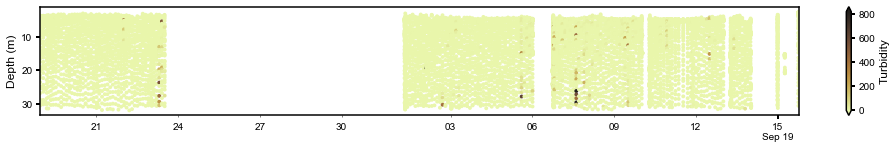

In [90]:
df['wetlab_FDOM_NTU'] = (df['wetlab_FDOM']-51)*0.2022

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_FDOM_NTU'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.turbid)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Turbidity')
ax.set_ylabel('Depth (m)');

In [91]:
import seawater as sw
sigmat = sw.dens(s=df['Salinity (PSU)'],t=df['SB_Temp'],p=df['SB_Depth']) - 1000.

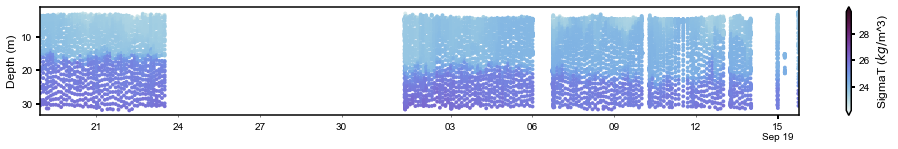

In [92]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=sigmat, 
                marker='o', edgecolor='none', cmap=cmocean.cm.dense)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

In [93]:
### Oxygen with Salinity Correction

### sal correct and convert oxygen
df['O2_corr'] = optode_O2_corr.O2_sal_comp(oxygen_conc=df['Optode_Dissolved_O2'],
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'])
df['O2_corr_umkg'] = optode_O2_corr.O2_molar2umkg(oxygen_conc=df.O2_corr,
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'],
                                     pressure=df['SB_Depth'])

df['O2PercentSat'] = optode_O2_corr.O2PercentSat(oxygen_conc=df.O2_corr_umkg,
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'],
                                     pressure=df['SB_Depth'])

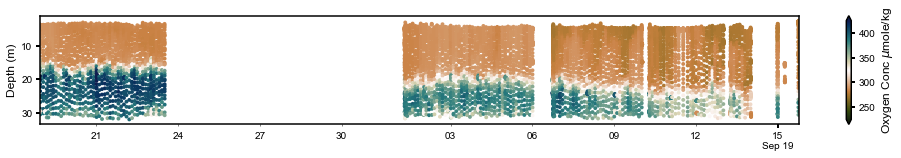

In [94]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2_corr_umkg'], 
                marker='o', vmin=225, vmax=425, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Conc $\mu$mole/kg')
ax.set_ylabel('Depth (m)');

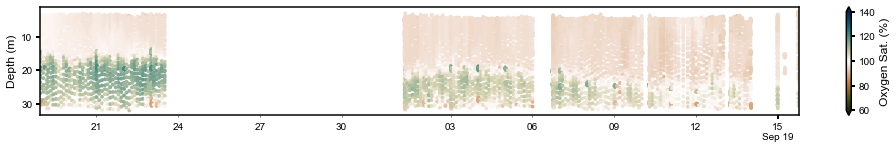

In [95]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2PercentSat'], 
                marker='o', vmin=60, vmax=140, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

### Calibration/Characterization Profiles - last 2 days

SDIG Group doesn't want to provide a dive profile identifier
- either I need to parse the ERDDAP data via time/depth or build my own counter from rudics data

In [96]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_19CKitaepr2a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2019-08-01T00:00:00Z',
    'time<=': '2019-10-10T00:00:00Z',
}

df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time (UTC),,,,,,,,,,
2019-09-15 18:41:31+00:00,302,7.920,30.675735,1.1526,0.6066,71.2167,-164.25,3.16,280.77435,94.65256
2019-09-15 18:41:39+00:00,302,7.917,30.678320,1.1752,0.6066,71.2167,-164.25,3.27,280.71146,94.62672
2019-09-15 18:41:47+00:00,302,7.918,30.677437,1.1752,0.4044,71.2167,-164.25,3.28,280.71370,94.62901
2019-09-15 18:41:55+00:00,302,7.917,30.678368,1.1526,0.4044,71.2167,-164.25,3.16,280.67947,94.61597
2019-09-15 18:42:03+00:00,302,7.917,30.678223,1.2204,0.2022,71.2167,-164.25,3.49,280.63930,94.60233


In [97]:
#groupby profile id


dfsub=df[(datetime.datetime.today()-datetime.timedelta(days=2)).strftime('%Y-%m-%d'):(datetime.datetime.today()).strftime('%Y-%m-%d')]
dfsg = dfsub.groupby('profile_id')

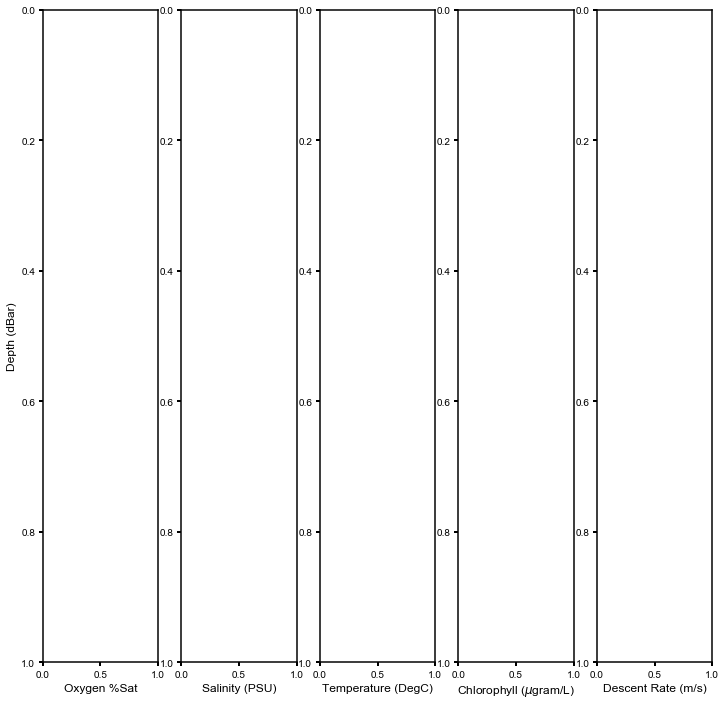

In [98]:
fig, ax = plt.subplots(1,5,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['depth'],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'],dfsg.get_group(cast)['depth'],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth'],'r-')
        cs = ax[3].plot(dfsg.get_group(cast)['Chlorophyll'],dfsg.get_group(cast)['depth'],'g-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['depth'],'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'],dfsg.get_group(cast)['depth'],'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth'],'k+')
        cs = ax[3].plot(dfsg.get_group(cast)['Chlorophyll'],dfsg.get_group(cast)['depth'],'k+')
    #dfsg.get_group(cast).to_csv(str(cast)+'.csv')

ax[0].set_xlabel('Oxygen %Sat')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()
ax[3].set_xlabel('Chlorophyll ($\mu$gram/L)')        
ax[3].invert_yaxis()
ax[4].set_xlabel('Descent Rate (m/s)')        
ax[4].invert_yaxis()

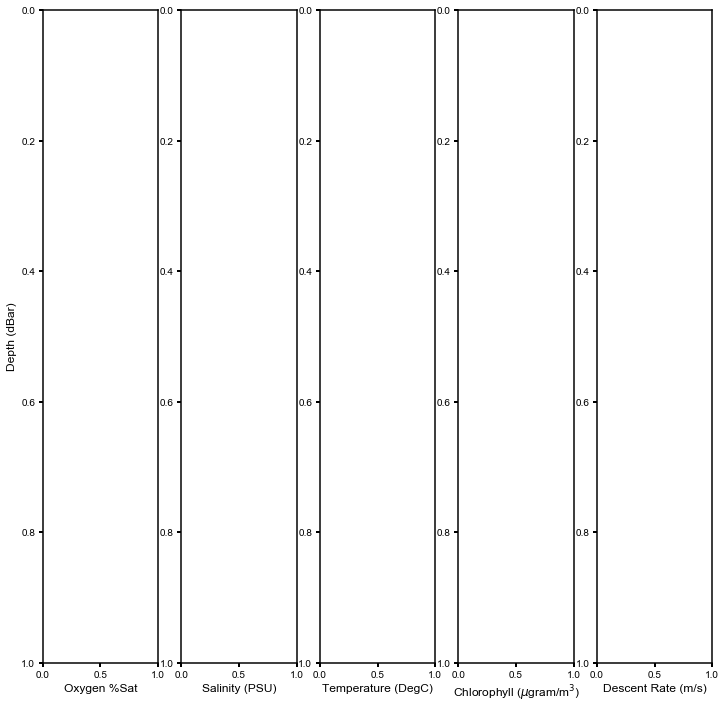

In [99]:
fig, ax = plt.subplots(1,5,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):

    if dfsg.get_group(cast)['depth'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'][1:],dfsg.get_group(cast)['depth'][1:],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'][1:],dfsg.get_group(cast)['depth'][1:],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'][1:],dfsg.get_group(cast)['depth'][1:],'r-')
        cs = ax[3].plot(dfsg.get_group(cast)['Chlorophyll'][1:],dfsg.get_group(cast)['depth'][1:],'g-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].last('s'),dfsg.get_group(cast)['depth'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'].last('s'),dfsg.get_group(cast)['depth'].last('s'),'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'].last('s'),dfsg.get_group(cast)['depth'].last('s'),'k+')
        cs = ax[3].plot(dfsg.get_group(cast)['Chlorophyll'].last('s'),dfsg.get_group(cast)['depth'].last('s'),'k+')

ax[0].set_xlabel('Oxygen %Sat')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()
ax[3].set_xlabel('Chlorophyll ($\mu$gram/m$^3$)')        
ax[3].invert_yaxis()
ax[4].set_xlabel('Descent Rate (m/s)')        
ax[4].invert_yaxis()

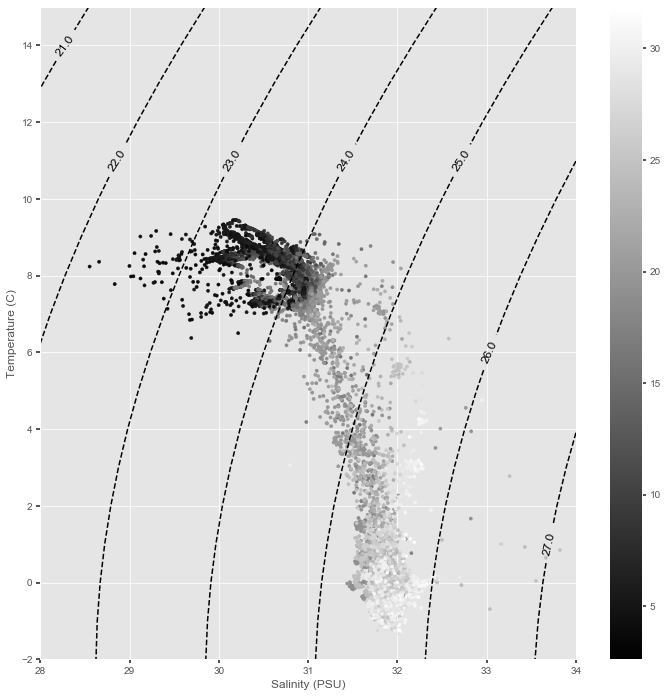

In [100]:

def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

fig = plot_salvtemp(df['Salinity'],df['Temperature'],df['depth'])

### Bin data to calculate integrate heat proxy (depth averaged temperature)

Setup 1m bins:
- code below will make all data deeper than prawler missing, thus biasing the averages to the upper 40m-50m.  Shapes may likely stay the same if the column is mixed, but maginitudes will be less.

In [101]:
#depth averaged temp - interpolate to 1m bins before averaging
def depth_ave(param, print_values=False):
    dfint= df.groupby('profile_id')

    fig, ax = plt.subplots(figsize=(17, 2))

    for i,cast in enumerate(dfint.groups):
        if dfint.get_group(cast)['depth'].std() > 1:
            #only use available data... bias towards prawler
            IntTemp = np.interp(np.arange(0,40,1),dfint.get_group(cast)['depth'], dfint.get_group(cast)[param], right=np.nan, left=np.nan)
            cs = ax.scatter(dfint.get_group(cast).index[0], np.nanmean(IntTemp), s=15, c='g', marker='o', edgecolor='none')
            
            #extrapolate to top and bottom
            IntTemp = np.interp(np.arange(0,40,1),dfint.get_group(cast)['depth'], dfint.get_group(cast)[param])
            cs = ax.scatter(dfint.get_group(cast).index[0], np.nanmean(IntTemp), s=15, c='r', marker='o', edgecolor='none')
            
            if print_values:
                print("{0},{1}".format(dfint.get_group(cast).index[0], np.nanmean(IntTemp)))

        xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
        ax.xaxis.set_major_locator(DayLocator(bymonthday=[30,15]))
        ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
        ax.xaxis.set_minor_formatter(DateFormatter('%d'))
        ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
        ax.xaxis.set_tick_params(which='major', pad=15)
        ax.xaxis.set_tick_params(which='minor', pad=5)

        ax.set_ylabel(param)
        ax.set_xlabel('Time (UTC)')  


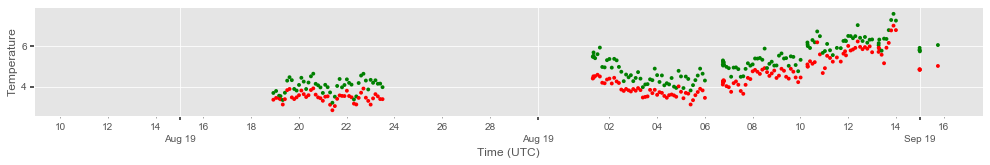

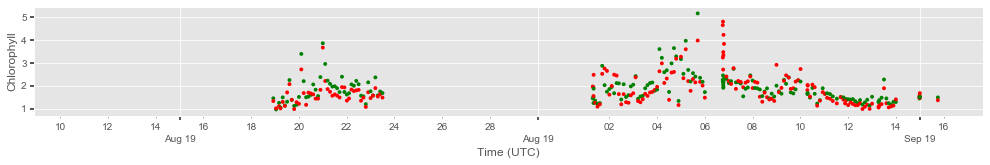

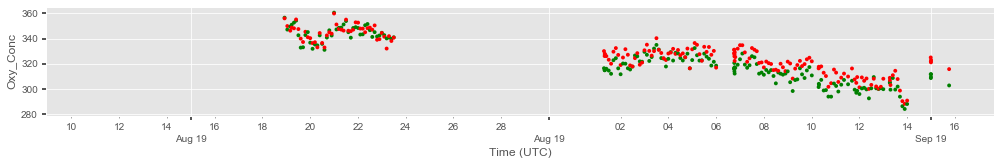

In [102]:
#depth averaged temp - interpolate to 1m bins before averaging
depth_ave('Temperature',print_values=False)
#depth averaged chlor - interpolate to 1m bins before averaging
depth_ave('Chlorophyll')
#depth averaged oxy - interpolate to 1m bins before averaging
depth_ave('Oxy_Conc')

- Above plots, red plots result from extrapolating the last point down to 40m , and up to the sfc then taking the mean.  Green points result from making all data below the prawler and above the prawler, "missing" and then taking the mean.